# LDA from Scratch
My revised tutorial based on https://www.depends-on-the-definition.com/lda-from-scratch/

I also found another similar tutorial at https://gist.github.com/umbertogriffo/5041b9e4ec6c3478cef99b8653530032

The latent Dirichlet allocation model
The LDA model is a generative statisitcal model of a collection of docuemnts. The basic idea is that documents are represented as random mixtures over latent topics, where each topic is characterized by a distribution over words. We describe what we mean by this I a second, first we need to fix some parameters.

- $T$ denotes the number of topics,
- $D$ denotes the number of documents,
- $V$ denotes the number of different works in the vocabulary,
- $N$ is number of words in a given document, so document $i$ has $N_i$ words,
- $w_{ij}$ is the specific $j^{th}$ word in document $i$ and
- $z_{ij}$ is the topic for the $j^{th}$ word in document $i$
- $\theta$ is the distribution of topics over the documents, $θ_i$ is the topic distribution for document $i$, which is just a probability vector. 
- $\phi$ is the distribution of words for a topic. $\phi_k$ is the word distribution for topic $k$.
- $\alpha$ is the parameter of the Dirichlet prior on the per-document topic distributions 
- $\beta$ is the parameter of the Dirichlet prior on the per-topic word distribution.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.usetex = True # use latex in plots
from tqdm.notebook import tqdm # progress bar

In [3]:
# get the newsgroup dataset

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
n_samples = 10000

In [5]:
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True,
                             )

In [6]:
data_samples = data[:n_samples]

In [7]:
data_samples[0] # the first news

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [8]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=10000,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

In [9]:
vocabulary = tf_vectorizer.vocabulary_

In [15]:
first10pairs = {k: vocabulary[k] for k in list(vocabulary)[:10]}
first10pairs

{'sure': 8732,
 'story': 8592,
 'did': 3018,
 'biased': 1573,
 'disagree': 3066,
 'statement': 8525,
 'media': 5785,
 'reputation': 7610,
 'pro': 7067,
 'israeli': 4985}

In [11]:
docs = []
for row in tf.toarray():
    present_words = np.where(row!=0)[0].tolist()
    present_words_with_count = []
    for word_idx in present_words:
        for count in range(row[word_idx]):
            present_words_with_count.append(word_idx)
    docs.append(present_words_with_count)

In [12]:
tf # each row is a news

&lt;10000x10000 sparse matrix of type &#39;&lt;class &#39;numpy.int64&#39;&gt;&#39;
	with 514753 stored elements in Compressed Sparse Row format&gt;

In [13]:
docs[0] # the first news encoded using word IDs

[874,
 1322,
 1356,
 1395,
 1573,
 2173,
 2291,
 2756,
 2879,
 2937,
 3018,
 3066,
 3520,
 3522,
 3587,
 4190,
 4195,
 4282,
 4373,
 4501,
 4643,
 4985,
 4985,
 5043,
 5391,
 5486,
 5527,
 5643,
 5785,
 5785,
 5785,
 5785,
 6354,
 6955,
 7067,
 7336,
 7423,
 7428,
 7441,
 7590,
 7595,
 7610,
 8153,
 8359,
 8525,
 8592,
 8732,
 8978,
 9156,
 9200,
 9310,
 9798]

In [14]:
# sanity check about the word encoding
# get the words of the first news
first_news_encoded = dict((k, v) for k, v in vocabulary.items() if v in docs[0])
print(data_samples[0]) # the first news
print(first_news_encoded) # first news encoded - the key words are kept

Well i&#39;m not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.

{&#39;sure&#39;: 8732, &#39;story&#39;: 8592, &#39;did&#39;: 3018, &#39;biased&#39;: 1573, &#39;disagree&#39;: 3066, &#39;statement&#39;: 8525,

In [15]:
# define variables

D = len(docs)        # number of documents
V = len(vocabulary)  # size of the vocabulary 
T = 10               # number of topics

beta = 1 / T         # parameter of the Dirichlet prior on the per-document topic distributions
alpha = 1 / T        # parameter of the Dirichlet prior on the per-topic word distribution

### Gibbs Sampling
What Gibbs sampling does in its most standard implementation, is it just cycles through all variables and model parameters and randomly samples each one from a conditional distribution where we’re conditioning on the previously sampled values of all the other model parameters and assignment variables, and we’re also conditioning on our observations. Because of the special structure of our LDA model, we can actually analytically marginalize over all of the uncertainty in our model parameters and just sample the word assignment variables $z_{ij}$. This is called “collapsed gibbs sampling”.

We do the sampling of a new topic $z_{ij}$ for a word $w_{ij}$ by the following formula:

$\large P(z_{ij}|z_{kl} \ \text{with} \ k\neq i \ \text{and} \ l \neq j, w) = \frac{\theta_{ik}\alpha}{N_i + \alpha T} \frac{\phi_{kw} + \beta}{\Sigma_{w \in V}\phi_{kw} + \beta V}$


In [16]:
%%time
# Wall time: 8min 46s
z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j
theta_d_z = np.zeros((D, T))
phi_z_w = np.zeros((T, V))
n_d = np.zeros((D))
n_z = np.zeros((T))

## Initialize the parameters
# m: doc id
for d, doc in enumerate(docs):  
    # n: id of word inside document, w: id of the word globally
    for n, w in enumerate(doc):
        # assign a topic randomly to words
        z_d_n[d][n] = n % T
        # get the topic for word n in document m
        z = z_d_n[d][n]
        # keep track of our counts
        theta_d_z[d][z] += 1
        phi_z_w[z, w] += 1
        n_z[z] += 1
        n_d[d] += 1

for iteration in tqdm(range(10)):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word n in document m
            z = z_d_n[d][n]
            
            # decrement counts for word w with associated topic z
            theta_d_z[d][z] -= 1 
            phi_z_w[z, w] -= 1
            n_z[z] -= 1

            # sample new topic from a multinomial according to our formular
            p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + T * alpha) 
            p_t_w = (phi_z_w[:, w] + beta) / (n_z + V * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            new_z = np.random.multinomial(1, p_z).argmax()

            # set z as the new topic and increment counts
            z_d_n[d][n] = new_z
            theta_d_z[d][new_z] += 1
            phi_z_w[new_z, w] += 1
            n_z[new_z] += 1


CPU times: user 7min 39s, sys: 10.6 s, total: 7min 50s
Wall time: 13min 49s


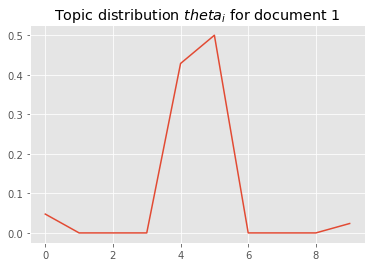

In [17]:
# After fitting the model we get the topic distribution over every document encoded in theta
i = 1
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]));
plt.title("Topic distribution $theta_i$ for document {}".format(i));

In [18]:
# look at the most probable words per topic by looking at the distribution over words for topic k in phi_k
inv_vocabulary = {v: k for k, v in vocabulary.items()}
n_top_words = 10
for topic_idx, topic in enumerate(phi_z_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: 00 10 25 20 15 12 16 11 team game
Topic #1: armenian like armenians time years space year just university new
Topic #2: use key file encryption like number information used chip know
Topic #3: space like just don new know time good use car
Topic #4: god people don think just does believe jesus know like
Topic #5: like know just don time does edu people use information
Topic #6: edu windows use file window software data com db available
Topic #7: ax max g9v b8f a86 pl 75u 1t bhj giz
Topic #8: cx w7 ah c_ chz lk mv hz t7 uw
Topic #9: people think said don mr just right did government say
